In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e20/sample_submission.csv
/kaggle/input/playground-series-s3e20/train.csv
/kaggle/input/playground-series-s3e20/test.csv


### **Analysis Setup**

In [2]:
#import data sets + overview
train_set = pd.read_csv("/kaggle/input/playground-series-s3e20/train.csv")
test_set = pd.read_csv("/kaggle/input/playground-series-s3e20/test.csv")
train_set.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,...,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,...,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,...,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381
3,ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,NaN,NaN,NaN,NaN,NaN,...,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286
4,ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,...,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317


In [3]:
train_set.shape

(79023, 76)

We notice that we have 76 columns, meaning a **substantial number of variables**. By checking the correlations down below, we can observe that there are a lot of variables that appear to be almost perfectly correlated and also a lot that appear **highly correlated**. \
This is coherent with the idea of the data set containing 7 features having sub features

In [4]:
subset1 = train_set.loc[:, "SulphurDioxide_SO2_column_number_density":]
cor_matrix = subset1.corr()
cor_matrix = pd.DataFrame(cor_matrix)
cor_matrix[(cor_matrix > 0.6) & (cor_matrix < 1.0)].stack()

SulphurDioxide_SO2_column_number_density        SulphurDioxide_SO2_slant_column_number_density              0.967078
                                                SulphurDioxide_SO2_column_number_density_15km               0.928253
SulphurDioxide_SO2_column_number_density_amf    Formaldehyde_tropospheric_HCHO_column_number_density_amf    0.725906
SulphurDioxide_SO2_slant_column_number_density  SulphurDioxide_SO2_column_number_density                    0.967078
                                                SulphurDioxide_SO2_column_number_density_15km               0.956979
                                                                                                              ...   
Cloud_solar_zenith_angle                        CarbonMonoxide_solar_zenith_angle                           0.795266
                                                NitrogenDioxide_solar_zenith_angle                          0.662231
                                                Formaldehyde_sol

At this point a good practice would be to **reduce the dimensionality** of the data by working with a more simple dataset. 
Idea: **Principal component analysis**

In [44]:
#Remove the target from the data
x_train = train_set.loc[:, "SulphurDioxide_SO2_column_number_density":"Cloud_solar_zenith_angle"]
colnames = x_train.columns.tolist() #retrieve the column names for later, it will be useful

**Data imputation, median strategy**  \
we use scikit-learn simple imputer. We choose the median since it is more robust and we have a suitable number of observation

In [45]:
#Data imputation
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
imputer.fit(x_train)
x_train = imputer.transform(x_train)
x_train = pd.DataFrame(x_train)

**Standardization**

In [46]:
#Then we standardize in order to have the same measurement order
from sklearn.preprocessing import StandardScaler
x_train = StandardScaler().fit_transform(x_train)
x_train = pd.DataFrame(x_train)
x_train.columns = colnames #apply column names since using numpy makes us lose them

Here is how our final training set looks like before PCA

In [47]:
x_train.head()

,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,...,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
0,-0.617429,-1.354297,-0.524140,1.499215,-1.547623,1.044395,-1.363791,1.621867,-0.502447,0.376229,...,0.051417,-1.353704,0.184638,-1.516525,-0.262503,0.016720,-0.060518,-0.750348,-1.378504,0.643142
1,-0.093107,-0.607616,-0.099088,-0.435488,0.436785,0.128105,-1.678091,0.232884,-0.011669,0.570764,...,1.223531,-1.363005,0.836687,-1.103670,-0.771638,-0.297013,1.359108,-0.137864,-1.548103,-0.154131
2,1.915273,-0.488422,1.898900,-0.760890,1.405035,1.202917,-1.948650,-0.924786,1.746621,0.370841,...,0.324464,-0.965708,0.071939,-0.851500,0.147214,-0.413264,0.864367,-1.566521,-1.477470,-0.395221
3,-0.080220,-0.125087,-0.072069,0.043473,-0.063415,0.022210,0.095731,0.074776,-0.073316,0.615263,...,-0.973267,-0.255427,-0.925955,-0.360982,-0.275948,-0.191248,-0.016413,-2.506101,-1.216246,0.205146
4,-0.497103,-0.917262,-0.428799,-0.587935,0.221928,-0.155368,-1.577465,-0.698516,-0.508619,0.259343,...,0.779400,-1.131698,0.480018,-0.969997,-0.814270,-0.722791,1.629005,-0.475633,-1.450702,-1.303718


### **PCA**
We choose 7 since the main features are 7

In [71]:
pca = PCA(n_components = 7)
pca_emission = pca.fit_transform(x_train)
column_names = ["p_component_" + str(i) for i in range(1,8)]
x_train_pca = pd.DataFrame(data=pca_emission, columns=column_names)
x_train_pca.head()

,p_component_1,p_component_2,p_component_3,p_component_4,p_component_5,p_component_6,p_component_7
0,-1.443849,1.721517,0.549952,-0.957257,2.272263,0.030605,-0.149755
1,-1.545999,-0.555142,0.128505,-2.997035,4.375122,0.808787,-0.327631
2,-3.303435,1.034167,-0.423192,-3.300847,1.108236,0.855897,-1.868697
3,-2.925800,-0.136118,0.663870,0.522492,0.624303,0.871925,-0.312234
4,-2.448328,-2.163808,0.415695,-0.479555,4.267561,0.392149,-0.166643


In [86]:
exvariance_dict = {"Factor":["p_component_" + str(i) for i in range(1,8)],
                   "Explained Variance": pca.explained_variance_ratio_.tolist(), 
                   "Total Variance Explained": np.cumsum(pca.explained_variance_ratio_.tolist())}
pd.DataFrame(exvariance_dict)

,Factor,Explained Variance,Total Variance Explained
0,p_component_1,0.140625,0.140625
1,p_component_2,0.101506,0.242132
2,p_component_3,0.079125,0.321256
3,p_component_4,0.056455,0.377711
4,p_component_5,0.052932,0.430644
5,p_component_6,0.046492,0.477135
6,p_component_7,0.041112,0.518248


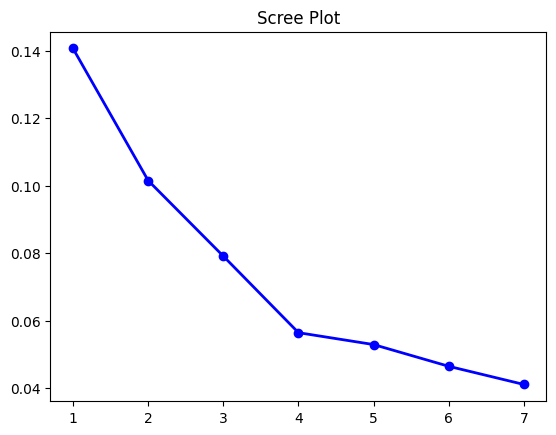

In [92]:
import matplotlib.pyplot as plt
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.show()

I would say that 7 is not enough, so we increase the number up to 12, it is stil a huge cut in term of number of variables. The scree plot "elbow" is still a rule of thumb, by following this idea we should have stop at 4, so it makes sense to still procede.

In [97]:
pca = PCA(n_components = 12)
pca_emission = pca.fit_transform(x_train)
column_names = ["p_component_" + str(i) for i in range(1,13)]
x_train_pca = pd.DataFrame(data=pca_emission, columns=column_names)
x_train_pca.head()
exvariance_dict = {"Factor":["p_component_" + str(i) for i in range(1,13)],
                   "Explained Variance": pca.explained_variance_ratio_.tolist(), 
                   "Total Variance Explained": np.cumsum(pca.explained_variance_ratio_.tolist())}
pd.DataFrame(exvariance_dict)

,Factor,Explained Variance,Total Variance Explained
0,p_component_1,0.140625,0.140625
1,p_component_2,0.101506,0.242132
2,p_component_3,0.079125,0.321256
3,p_component_4,0.056455,0.377711
4,p_component_5,0.052932,0.430644
5,p_component_6,0.046493,0.477137
6,p_component_7,0.041114,0.518251
7,p_component_8,0.040881,0.559132
8,p_component_9,0.038960,0.598092
9,p_component_10,0.032543,0.630635


In [105]:
#Here we repeat the same for test set

x_test = test_set.loc[:, "SulphurDioxide_SO2_column_number_density":"Cloud_solar_zenith_angle"]
colnames = x_test.columns.tolist() #retrieve the column names for later, it will be useful
#Data imputation
imputer = SimpleImputer(strategy='median')
imputer.fit(x_test)
x_test = imputer.transform(x_test)
x_test = pd.DataFrame(x_test)
#Then we standardize in order to have the same measurement order
x_test = StandardScaler().fit_transform(x_test)
x_test = pd.DataFrame(x_test)
x_test.columns = colnames #apply column names since using numpy makes us lose them
pca = PCA(n_components = 12)
pca_emission = pca.fit_transform(x_test)
column_names = ["p_component_" + str(i) for i in range(1,13)]
x_test_pca = pd.DataFrame(data=pca_emission, columns=column_names)
x_test_pca.head()
exvariance_dict2 = {"Factor":["p_component_" + str(i) for i in range(1,13)],
                   "Explained Variance": pca.explained_variance_ratio_.tolist(), 
                   "Total Variance Explained": np.cumsum(pca.explained_variance_ratio_.tolist())}
pd.DataFrame(exvariance_dict2)

,Factor,Explained Variance,Total Variance Explained
0,p_component_1,0.178922,0.178922
1,p_component_2,0.100700,0.279622
2,p_component_3,0.073173,0.352794
3,p_component_4,0.052510,0.405304
4,p_component_5,0.048432,0.453736
5,p_component_6,0.044503,0.498239
6,p_component_7,0.040488,0.538728
7,p_component_8,0.038873,0.577601
8,p_component_9,0.035192,0.612793
9,p_component_10,0.033230,0.646023


Notice how PCA seems equally effective over the test set. We expect low bias from this

### **Prediction task**

In [106]:
y_train = train_set.loc[:, "emission"]
y_test = pd.read_csv("/kaggle/input/playground-series-s3e20/sample_submission.csv")
#x_train_pca
#x_test_pca

For modeling we procede with a Random Forest. We procede with the tuning

In [121]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

sampled_xtrain = x_train_pca.sample(n = 20000, random_state = 22)
indeces = sampled_xtrain.index
sampled_ytrain = y_train[indeces]

search_space_m1 = {
    "n_estimators": [100,200,300], # number of trees
    "max_depth": [5,7,10,15],
}

rf_model = RandomForestRegressor(random_state = 22)
GS_rf =  GridSearchCV(estimator = rf_model, param_grid = search_space_m1, scoring = "neg_root_mean_squared_error", cv = 3, verbose = 4)
GS_rf.fit(sampled_xtrain,sampled_ytrain)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END ..max_depth=5, n_estimators=100;, score=-141.529 total time=   6.6s
[CV 2/3] END ..max_depth=5, n_estimators=100;, score=-135.855 total time=   6.6s
[CV 3/3] END ..max_depth=5, n_estimators=100;, score=-158.820 total time=   6.5s
[CV 1/3] END ..max_depth=5, n_estimators=200;, score=-141.297 total time=  13.1s
[CV 2/3] END ..max_depth=5, n_estimators=200;, score=-135.802 total time=  13.2s
[CV 3/3] END ..max_depth=5, n_estimators=200;, score=-158.793 total time=  13.0s
[CV 1/3] END ..max_depth=5, n_estimators=300;, score=-141.273 total time=  19.8s
[CV 2/3] END ..max_depth=5, n_estimators=300;, score=-135.796 total time=  19.7s
[CV 3/3] END ..max_depth=5, n_estimators=300;, score=-158.793 total time=  19.5s
[CV 1/3] END ..max_depth=7, n_estimators=100;, score=-142.067 total time=   8.9s
[CV 2/3] END ..max_depth=7, n_estimators=100;, score=-136.639 total time=   8.9s
[CV 3/3] END ..max_depth=7, n_estimators=100;, s

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=22),
             param_grid={'max_depth': [5, 7, 10, 15],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_root_mean_squared_error', verbose=4)

It appears that the models are quite similar in terms of RMSE, so we should choose the most simple one here, 5 as max depth and 100 as n_estimators

In [124]:
pd.DataFrame(GS_rf.cv_results_, columns = ["mean_fit_time", "param_max_depth", "param_n_estimators",
                                                    "mean_test_score", "std_test_score"]).sort_values(by = "mean_test_score", ascending = False)

,mean_fit_time,param_max_depth,param_n_estimators,mean_test_score,std_test_score
2,19.563284,5,300,-145.287508,9.808380
1,13.066636,5,200,-145.297521,9.803289
0,6.532133,5,100,-145.401320,9.767288
5,26.594026,7,300,-145.816637,9.671526
4,17.729196,7,200,-145.857136,9.632725
3,8.845187,7,100,-145.955706,9.597305
8,36.118036,10,300,-146.400159,9.578600
7,24.072295,10,200,-146.556391,9.507656
6,12.069518,10,100,-146.746901,9.426166
11,49.914308,15,300,-146.991625,9.469215


In [128]:
rf_model = RandomForestRegressor(random_state = 22, max_depth = 5, n_estimators= 100)
rf_model.fit(x_train_pca, y_train)
y_pred = rf_model.predict(x_test_pca)

In [134]:
mean_squared_error(y_test["emission"],y_pred) #This looks promising!

75.89880576094396

In [151]:
#Import and use MAPE to have an idea of our average percentage error
from sklearn.metrics import mean_absolute_percentage_error
str(round(mean_absolute_percentage_error(y_test["emission"],y_pred),3)*100) +"%"

'6.9%'

**By using this Random Forest and constructing a more simple analysis with a huge dimensionality reduction, we totalize a 6.9% average error on the prediction; definetely an encouraging result.**